# Plan B Policy Summary (Hierarchical CI)

Compute dataset-level averages for `initial_dice`, `final_dice`, and `iterations_used`
across all tasks in a procedure (optionally filtered by dataset family), using
the hierarchical CI utilities.


In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import sys

repo_root = Path("/data/ddmg/mvseg-ordering")
for path in [repo_root, repo_root / "UniverSeg", repo_root / "MultiverSeg"]:
    if str(path) not in sys.path:
        sys.path.append(str(path))

from experiments.analysis.planb_utils import load_planb_summaries
from experiments.analysis.hierarchical_ci import (
    compute_subset_scores,
    hierarchical_bootstrap_task_estimates,
    dataset_bootstrap_stats,
)


In [2]:
# ---- Configuration ----
procedure = "random_v_MSE_v2"
ablation = "pretrained_baseline"
datasets = ["ACDC", "BTCV", "WBC", "BUID"]  # dataset families to report
metrics = ["initial_dice", "final_dice", "iterations_used"]
n_boot = 100
seed = 0


In [3]:
def policy_metric_hier_ci(df_pol: pd.DataFrame, metric: str):
    subset_scores = compute_subset_scores(df_pol, metric)
    subset_scores_by_task = {
        str(task): grp['subset_mean'].to_numpy(dtype=float)
        for task, grp in subset_scores.groupby('task_id')
    }
    task_boot = hierarchical_bootstrap_task_estimates(
        subset_scores_by_task, n_boot=n_boot, seed=seed
    )
    dataset_boot, mean, lo, hi = dataset_bootstrap_stats(task_boot, alpha=0.05)
    return mean, lo, hi



In [4]:
tables = {}
for dataset in datasets:
    df = load_planb_summaries(
        repo_root=repo_root,
        procedure=procedure,
        ablation=ablation,
        dataset=dataset,
        filename="subset_support_images_summary.csv",
    )
    rows = []
    for policy in sorted(df['policy_name'].unique()):
        df_pol = df[df['policy_name'] == policy]
        row = {'policy': policy}
        for metric in metrics:
            if metric not in df_pol.columns:
                row[f'{metric}_mean'] = float('nan')
                row[f'{metric}_ci_lo'] = float('nan')
                row[f'{metric}_ci_hi'] = float('nan')
                continue
            try:
                mean, lo, hi = policy_metric_hier_ci(df_pol, metric)
            except Exception as exc:
                print(f'Warning: dataset={dataset} policy={policy} metric={metric} failed: {exc}')
                mean, lo, hi = float('nan'), float('nan'), float('nan')
            row[f'{metric}_mean'] = mean
            row[f'{metric}_ci_lo'] = lo
            row[f'{metric}_ci_hi'] = hi
        rows.append(row)
    table = pd.DataFrame(rows)
    tables[dataset] = table
    print(f'--- {dataset} ---')
    display(table)


--- ACDC ---


,policy,initial_dice_mean,initial_dice_ci_lo,initial_dice_ci_hi,final_dice_mean,final_dice_ci_lo,final_dice_ci_hi,iterations_used_mean,iterations_used_ci_lo,iterations_used_ci_hi
0,mse_alternate_start_max,0.585027,0.569527,0.599253,0.823747,0.816899,0.829584,11.386278,11.083575,11.699838
1,mse_alternate_start_min,0.585791,0.570547,0.601090,0.823926,0.817159,0.829739,11.395408,11.076313,11.689900
2,mse_max,0.584502,0.567381,0.598796,0.823478,0.816511,0.829487,11.382228,11.092942,11.679638
3,mse_min,0.588553,0.575673,0.600734,0.823557,0.816587,0.829427,11.414192,11.103262,11.714983
4,random,0.586439,0.574759,0.597394,0.823649,0.816833,0.829414,11.386914,11.088559,11.669451


--- BTCV ---


,policy,initial_dice_mean,initial_dice_ci_lo,initial_dice_ci_hi,final_dice_mean,final_dice_ci_lo,final_dice_ci_hi,iterations_used_mean,iterations_used_ci_lo,iterations_used_ci_hi
0,mse_alternate_start_max,0.523440,0.513931,0.532674,0.918974,0.917660,0.920242,3.176237,3.111420,3.260924
1,mse_alternate_start_min,0.525851,0.516610,0.534707,0.919183,0.918192,0.920075,3.173890,3.118459,3.239257
2,mse_max,0.522729,0.512184,0.533576,0.919188,0.918250,0.920078,3.164261,3.104472,3.232878
3,mse_min,0.523795,0.515680,0.532621,0.919329,0.918420,0.920012,3.156152,3.109652,3.215081
4,random,0.523559,0.514482,0.533115,0.919276,0.918399,0.919948,3.157819,3.108845,3.222850


--- WBC ---


,policy,initial_dice_mean,initial_dice_ci_lo,initial_dice_ci_hi,final_dice_mean,final_dice_ci_lo,final_dice_ci_hi,iterations_used_mean,iterations_used_ci_lo,iterations_used_ci_hi
0,mse_alternate_start_max,0.772309,0.757021,0.785588,0.972878,0.971062,0.974684,6.053565,5.340712,6.777425
1,mse_alternate_start_min,0.774726,0.758967,0.788082,0.972970,0.971118,0.974793,6.077320,5.344869,6.804794
2,mse_max,0.772167,0.760462,0.783254,0.972933,0.971152,0.974683,6.064385,5.407106,6.754150
3,mse_min,0.778308,0.764154,0.788682,0.972960,0.971061,0.974827,6.114985,5.360556,6.844413
4,random,0.776557,0.764970,0.785948,0.972912,0.971066,0.974758,6.105674,5.390329,6.839122


--- BUID ---


,policy,initial_dice_mean,initial_dice_ci_lo,initial_dice_ci_hi,final_dice_mean,final_dice_ci_lo,final_dice_ci_hi,iterations_used_mean,iterations_used_ci_lo,iterations_used_ci_hi
0,mse_alternate_start_max,0.528793,0.497767,0.556447,0.971901,0.971039,0.972832,1.230455,1.096925,1.380887
1,mse_alternate_start_min,0.518749,0.484538,0.545372,0.971905,0.971007,0.972790,1.236665,1.104162,1.378788
2,mse_max,0.530157,0.494498,0.555889,0.971943,0.971024,0.972892,1.235150,1.093500,1.397550
3,mse_min,0.512986,0.477332,0.542634,0.971699,0.970751,0.972562,1.247885,1.151663,1.364150
4,random,0.522888,0.487310,0.550418,0.971812,0.971000,0.972711,1.247262,1.139695,1.380497


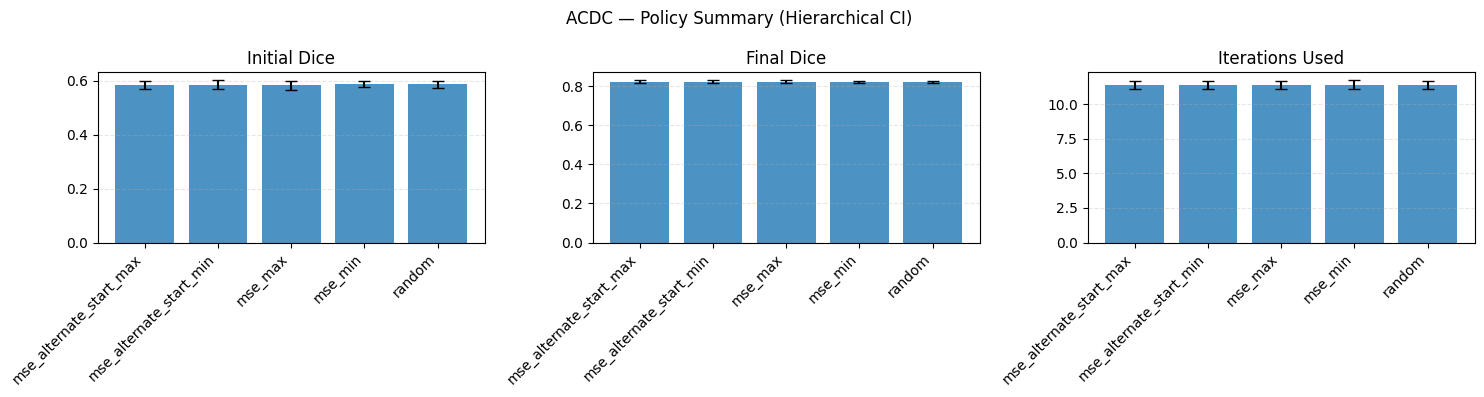

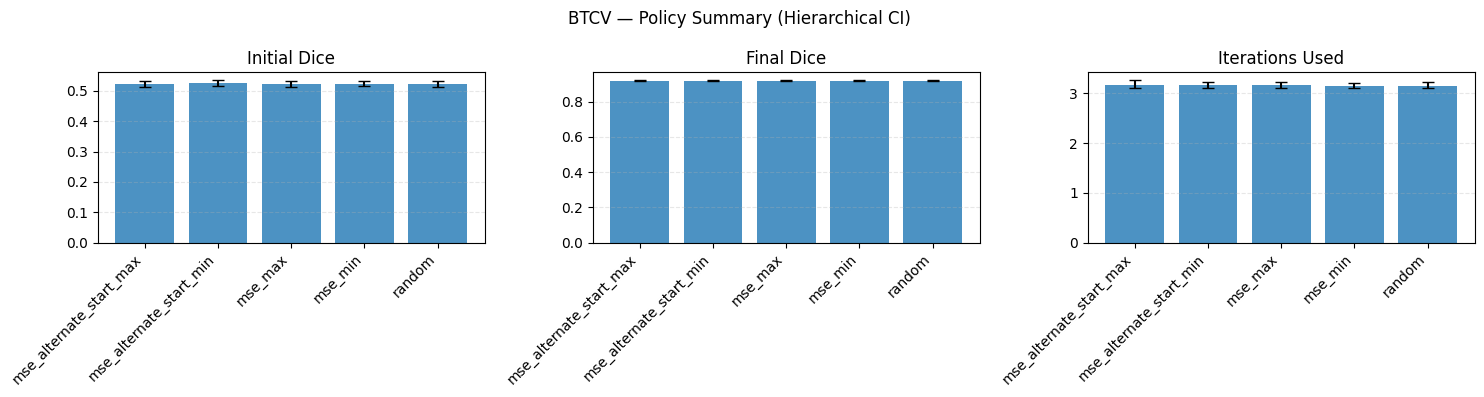

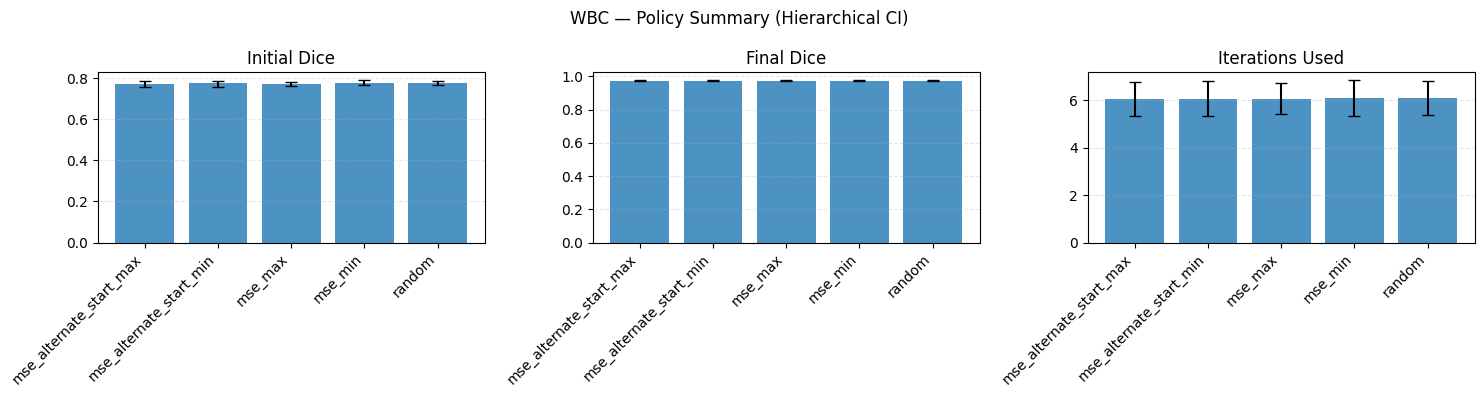

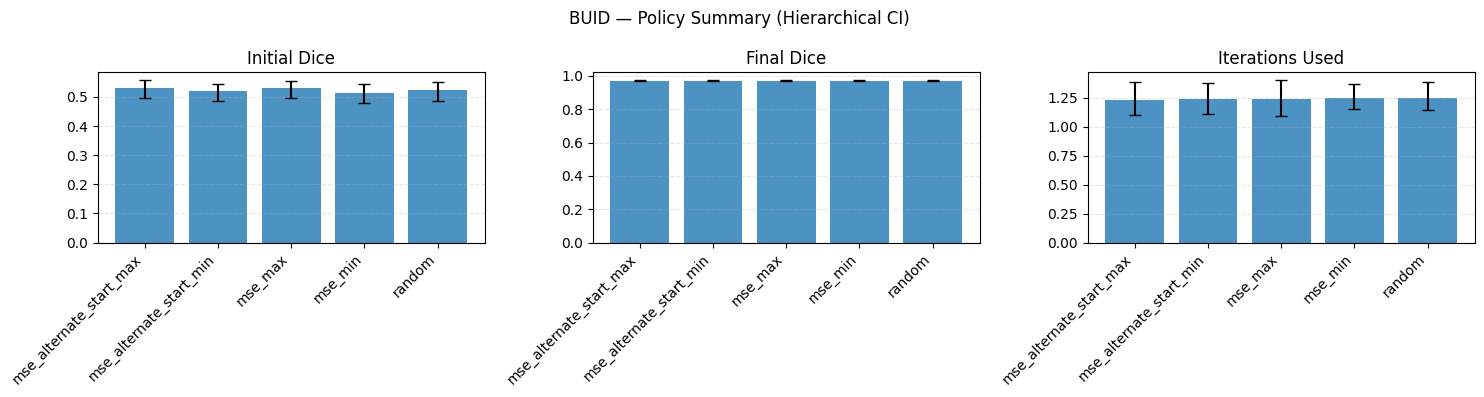

In [5]:
# --- Bar charts with hierarchical CI (one chart per dataset, all 3 metrics) ---
import matplotlib.pyplot as plt

metric_labels = {
    "initial_dice": "Initial Dice",
    "final_dice": "Final Dice",
    "iterations_used": "Iterations Used",
}

for dataset in datasets:
    if dataset not in tables:
        continue
    df_plot = tables[dataset].copy()
    if df_plot.empty:
        continue
    policies = df_plot["policy"].tolist()
    x = range(len(policies))

    fig, axes = plt.subplots(1, len(metrics), figsize=(5 * len(metrics), 4), sharey=False)
    if len(metrics) == 1:
        axes = [axes]

    for ax, metric in zip(axes, metrics):
        mean_col = f"{metric}_mean"
        lo_col = f"{metric}_ci_lo"
        hi_col = f"{metric}_ci_hi"
        if mean_col not in df_plot:
            continue
        means = df_plot[mean_col].to_numpy()
        lo = df_plot[lo_col].to_numpy()
        hi = df_plot[hi_col].to_numpy()
        yerr = [means - lo, hi - means]
        ax.bar(x, means, yerr=yerr, capsize=4, alpha=0.8)
        ax.set_xticks(list(x))
        ax.set_xticklabels(policies, rotation=45, ha="right")
        ax.set_title(metric_labels.get(metric, metric))
        ax.grid(axis="y", linestyle="--", alpha=0.3)

    fig.suptitle(f"{dataset} — Policy Summary (Hierarchical CI)")
    fig.tight_layout()
    plt.show()



In [6]:
# Optional: save table
# out_path = repo_root / 'figures' / f'planB_policy_summary__{procedure}__{ablation}.csv'
# out_path.parent.mkdir(parents=True, exist_ok=True)
# table.to_csv(out_path, index=False)
# print(f'Wrote {out_path}')
